Чтобы подключиться к локальной сети, ввести
jupyter notebook --NotebookApp.allow_origin='https://colab.research.google.com'

#Сверточные нейронные сети (CNN)

Датасеты грибов
https://www.kaggle.com/datasets/maysee/mushrooms-classification-common-genuss-images

https://www.kaggle.com/datasets/derekkunowilliams/mushrooms

Соединим 2 датасета, поместив фотографии в одну папку

* Boletus - Подберезовик
*Entoloma - Энтолома (поганка)
*Russula - Сыроежка
*Suillus - Маслёнок
*Lactarius - Млечник
*Amanita - Мухомор
*Agaricus - Шампиньон
*Hygrocybe - влажноголовка 
*Cortinarius - Паутинник

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt             #visualisation     
import fastai
from fastai.vision import *
from fastai.vision.data import *
from fastai.vision.augment import aug_transforms
from fastai.metrics import error_rate
from pathlib import Path
#from fastai.vision.all import *

%reload_ext autoreload
%autoreload 2
%matplotlib inline

#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print("used:", device, "-", torch.cuda.get_device_name(0) if torch.cuda.is_available() else 'cpu')

used: cpu - cpu


In [ ]:
import torch
import torchvision
from torchvision import transforms
from torchvision.datasets import ImageFolder

#data_dir = "/content/drive/My Drive/NN/Mushrooms"
#test_data_dir = "/content/drive/My Drive/NN/Mushrooms_test"
data_dir = "D:\\stasya\\univer\\NN\\Mushrooms"
test_data_dir = "D:\\stasya\\univer\\NN\\Mushrooms_test"

#transform = transforms.Compose(
#    [transforms.ToTensor(),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])


# загружаем данные, делаем размер картинок 224х224,превращаем их в тензор
dataset = ImageFolder(data_dir,transform = transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))
test_dataset = ImageFolder(test_data_dir,transforms.Compose([
    transforms.Resize((224,224)),transforms.ToTensor()
]))

Если данные повреждены, все равно их загружаем, но при выводе ошибки не прекращаем работу. Это не работает, при обучении ошибка появляется. Найдем поврежденные файлы и удалим их
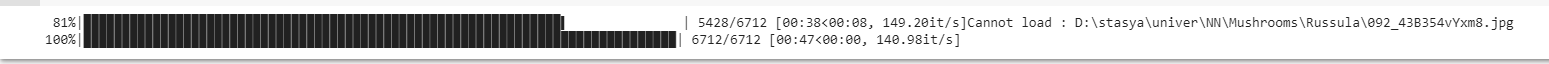


In [ ]:
#from PIL import ImageFile
#ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
from PIL import ImageFile
import tqdm

for DUT in [dataset]:
    for fn,label in tqdm.tqdm(DUT.imgs):
        try:
            im = ImageFile.Image.open(fn)
            im2 = im.convert('RGB')
        except OSError:
            print("Cannot load : {}".format(fn))

100%|█████████████████████████████████████████████████████████████████████████████| 6711/6711 [00:21<00:00, 309.31it/s]


In [ ]:
img, label = dataset[0]
print(img.shape,label)

torch.Size([3, 224, 224]) 0


У картинок размер 224х224 и цвета RGB (3)

In [ ]:
print("Выделенные классы: \n",dataset.classes)

Выделенные классы: 
 ['Agaricus', 'Amanita', 'Boletus', 'Cortinarius', 'Entoloma', 'Hygrocybe', 'Lactarius', 'Russula', 'Suillus']


Label : Agaricus


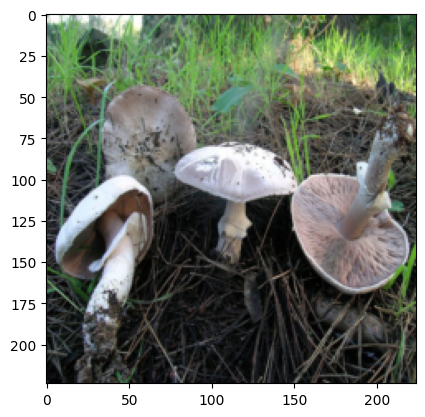

In [ ]:
# Выведем картинку
def display_img(img,label):
    plt.imshow(img.permute(1,2,0))
    print(f"Label : {dataset.classes[label]}")
    
#display_img(*dataset[random.randint(0, 6000)])
display_img(*dataset[1])

Разделяем данные на тренировочный и проверочный наборы

In [ ]:
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

batch_size = 32 # число изображений, которое будет передаваться в модель за раз для распараллеливания. Подбирается опытным путем. Можно взять до 64
val_size = 1000
train_size = len(dataset) - val_size 

train_data,val_data = random_split(dataset,[train_size,val_size])
print(f"Количество данных для тренировки: {len(train_data)}")
print(f"Количество данных для теста: {len(val_data)}")


Количество данных для тренировки: 5711
Количество данных для теста: 1000


In [ ]:
train_dl = DataLoader(train_data, batch_size, 
                      shuffle = True, # перемешать ли набор 
                      num_workers = 0) # многопроцессорная загрукза, количество процессов 
                      #pin_memory = True)
val_dl = DataLoader(val_data, batch_size, num_workers = 0)
                    #pin_memory = True) # перемещение данных в закрепленную память, позволяет быстро передавать данные, так как используется CUDA

Визуализируем картинки 1 батча

In [ ]:
# функция для показа изображения
def imshow(img):
    #img = img  / 2  + 0.5    
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# получаем несколько случайных тестовых изображений
dataiter = iter(train_dl)
images, labels = next(dataiter)

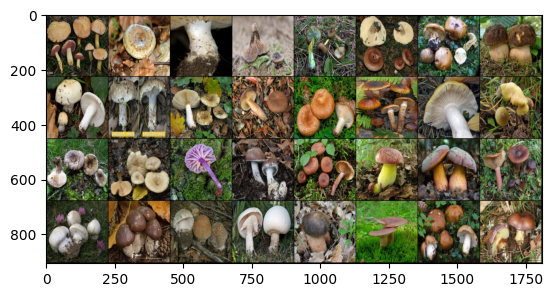

Suillus Lactarius Amanita Entoloma Entoloma Lactarius Cortinarius Boletus Russula Russula Russula Lactarius Lactarius Cortinarius Russula Entoloma Lactarius Lactarius Hygrocybe Cortinarius Lactarius Boletus Boletus Lactarius Agaricus Suillus Amanita Agaricus Boletus Lactarius Russula Cortinarius


In [ ]:
# показать изображения
imshow(torchvision.utils.make_grid(images))
# показать лейблы изображений
print(' '.join(f'{dataset.classes[labels[j]]}' for j in range(batch_size)))

#Делаем архитектуру

функция таймера

In [ ]:
from datetime import datetime
def timer(start_time=None):
    if not start_time:
        start_time = datetime.now()
        return start_time
    elif start_time:
        thour, temp_sec = divmod((datetime.now() - start_time).total_seconds(), 3600)
        tmin, tsec = divmod(temp_sec, 60)
        print('Затрачено времени: %i часов %i минут и %s секунд.' % (thour, tmin, round(tsec, 2)) + '\n')

# Запускать так
#start_time = timer(None)
# какой-то код
#timer(start_time)

## Архитектура 1. Активация Relu

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Инициализация модели
class Net1(nn.Module):
    def __init__(self):
        super().__init__()  # конструктор предка
        # 2D-свертка к входному сигналу
        # 224 224 3
        self.conv1 = nn.Conv2d(in_channels=3, # глубина фильтра (количество цветовых каналов, у нас RGB)
                               out_channels=8, # количество фильтров
                               kernel_size=4).to(device) # размер фильтра
        # 221 221 8, 224-(kernel_size-1) = 221
        self.pool1 = nn.MaxPool2d(2).to(device) # уменьшаем размер изображения в 2 раза
        # 110 110 8
        self.conv2 = nn.Conv2d(8, 32, 3).to(device)
        # 108 108 32
        self.pool2 = nn.MaxPool2d(2).to(device) # уменьшаем размер изображения в 2 раза
        # 54 54 32
        # Применяет линейное преобразование к входящим данным так, чтобы данные можно было разделить на классы 1 гиперплоскостью
        self.fc1 = nn.Linear(in_features=32*54*54, # размерность пр-ва на входе 
                             out_features=150).to(device) # размерность пр-ва на выходе 
        self.fc2 = nn.Linear(150, 9).to(device) # последнее число = количество классов
        self.relu = nn.ReLU().to(device)

    # Это forward функция, которая определяет структуру сети.
    def forward(self, x):
        x = self.conv1(x) # выход первого слоя
        x = self.relu(x) # функция активации выходов слоя
        x = self.pool1(x)
      
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)

        x = x.view(x.size(0),-1) #(input, start_dim) Сглаживает input путем преобразования его в одномерный тензор.
        # размерность 1 измерения остается неизменной, 
        # а все остальные измерения упаковываются в одно, так чтобы получился 2D тензор с сохранением общего числа элементов.
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)

        return x
    
    def __str__(self):
        return "Net1"

net1 = Net1()

**Conv2d**:
* число входных каналов (глубина фильтров)
* число выходных каналов (количество фильтров)
* размер ядра (ширина и высота фильтров) 
* stride - шаг, с которым фильтр скользит по стопке изображений (входных каналов)

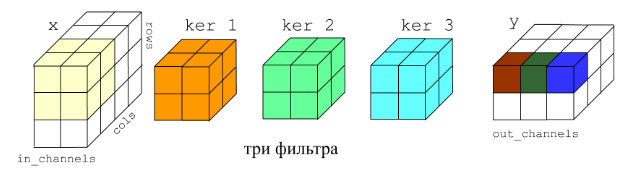



## Архитектура 2. Активация сигмоидами

In [ ]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()
        # 224 224 3
        self.conv1 = nn.Conv2d(in_channels=3, # глубина фильтра (количество цветовых каналов, у нас RGB)
                               out_channels=6, # количество фильтров
                               kernel_size=64).to(device) # размер фильтра
        # 161 161 6                 
        self.pool1 = nn.MaxPool2d(4).to(device)
        # 40 40 6
        self.conv2 = nn.Conv2d(6, 12, 12).to(device) 
        # 29 29 12
        self.pool2 = nn.MaxPool2d(2).to(device) 
        # 14 14 12
        self.fc1 = nn.Linear(12*14*14, 500).to(device)
        self.fc2 = nn.Linear(500, 100).to(device)
        self.fc3 = nn.Linear(100, 9).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.sigmoid(x)
        x = self.pool1(x)
      
        x = self.conv2(x)
        x = torch.sigmoid(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0),-1)
        x = torch.sigmoid(self.fc1(x))
        x = torch.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def __str__(self):
        return "Net2"

net2 = Net2()

## Архитектура 3.Релу и дропаут

Главная идея Dropout — вместо обучения одной DNN обучить ансамбль нескольких DNN, а затем усреднить полученные результаты.

In [ ]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()
        # 224 224 3
        self.conv1 = nn.Conv2d(in_channels=3, # глубина фильтра (количество цветовых каналов, у нас RGB)
                               out_channels=6, # количество фильтров
                               kernel_size=64).to(device) # размер фильтра
        # 161 161 6                 
        self.pool1 = nn.MaxPool2d(4).to(device)
        # 40 40 6
        self.drop1 = nn.Dropout(p=0.5) # часть нейронов, которую нужно отбросить

        self.conv2 = nn.Conv2d(6, 12, 12).to(device) 
        # 29 29 12
        self.pool2 = nn.MaxPool2d(2).to(device) 
        # 14 14 12
        self.drop2 = nn.Dropout(p=0.3)

        self.fc1 = nn.Linear(12*14*14, 500).to(device)
        self.fc2 = nn.Linear(500, 100).to(device)
        self.fc3 = nn.Linear(100, 9).to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.drop1(x)
      
        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.drop2(x)
        
        x = x.view(x.size(0),-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    def __str__(self):
        return "Net3"

net3 = Net3()

## Архитектура 4. Тангенс

In [ ]:
class Net4(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, # глубина фильтра (количество цветовых каналов, у нас RGB)
                               out_channels=12, # количество фильтров
                               kernel_size=3).to(device) # размер фильтра
        #222 222 12
        self.pool1 = nn.MaxPool2d(4).to(device)
        #55 55 12
        self.conv2 = nn.Conv2d(12, 32, 3).to(device)
        #53 53 32
        self.pool2 = nn.MaxPool2d(2).to(device)
        #26 26 32
        self.fc1 = nn.Linear(32*26*26, 150).to(device)
        self.fc3 = nn.Linear(150, 9).to(device)
        
        self.tanh = nn.Tanh().to(device)

    def forward(self, x):
        x = self.conv1(x)
        x = self.tanh(x)        
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.tanh(x)  
        x = self.pool2(x)      
        
        x = x.view(x.size(0),-1)
        x = self.fc1(x)
        x = self.tanh(x)
        x = self.fc3(x)
        return x
    
    def __str__(self):
        return "Net4"

net4 = Net4()

# Обучение

In [ ]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss() # softmax - преобразует вектор в число от 0 до 1

In [ ]:
best_models = []
models = [net1, net2, net3]
num_epochs = 15 # количество эпох
accs = {str(model): [] for model in models}

for net_num, model in enumerate(models):
   # засекаем время
    start_time = timer(None)

    model = model.to(device)
    best_model = None
    best_loss = 99999999999999.9
    best_epoch = -1
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, # Коэффициент скорости обучения, шаг изменения весов
                      momentum=0.9) # заменяет градиент импульсом - формула, которая корректирует изменение весов

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            # обнуляем градиенты параметров
            optimizer.zero_grad()      
            outputs = model(images)
            # loss смотрит, насколько далеко находятся полученные ответы от реальных
            loss = criterion(outputs, labels)
            # вычисляем градиенты  
            loss.backward()
            optimizer.step()            
            # вывести статистику обучения
            epoch_loss += loss.item()     
        print (f'Epoch [{epoch+1}], Loss: {epoch_loss:.4f}')

        # находим самую лучшую эпоху
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model = model.state_dict()
            best_epoch = epoch
    best_models.append(best_model)

    print(f'Finished Training {model}. Best epoch: {best_epoch+1}\n')
    # сколько времени работала 1 модель
    timer(start_time)


Epoch [1], Loss: 365.4294
Epoch [2], Loss: 353.2187
Epoch [3], Loss: 335.0957
Epoch [4], Loss: 321.9536
Epoch [5], Loss: 313.2737
Epoch [6], Loss: 305.9604
Epoch [7], Loss: 298.9059
Epoch [8], Loss: 289.2830
Epoch [9], Loss: 278.5481
Epoch [10], Loss: 268.9904
Epoch [11], Loss: 254.2099
Epoch [12], Loss: 240.3422
Epoch [13], Loss: 224.3789
Epoch [14], Loss: 207.5258
Epoch [15], Loss: 179.4052
Finished Training Net1. Best epoch: 15

Затрачено времени: 0 часов 18 минут и 9.8 секунд.

Epoch [1], Loss: 368.4192
Epoch [2], Loss: 364.8318
Epoch [3], Loss: 364.8876
Epoch [4], Loss: 364.6584
Epoch [5], Loss: 364.8220
Epoch [6], Loss: 364.8786
Epoch [7], Loss: 364.6560
Epoch [8], Loss: 364.5522
Epoch [9], Loss: 364.8034
Epoch [10], Loss: 364.6285
Epoch [11], Loss: 364.7115
Epoch [12], Loss: 364.6761
Epoch [13], Loss: 364.4643
Epoch [14], Loss: 364.6761
Epoch [15], Loss: 364.7659
Finished Training Net2. Best epoch: 13

Затрачено времени: 5 часов 19 минут и 40.73 секунд.

Epoch [1], Loss: 368.795

In [ ]:
best_models = []
models = [net4]
num_epochs = 15 # количество эпох
accs = {str(model): [] for model in models}

for net_num, model in enumerate(models):
   # засекаем время
    start_time = timer(None)

    model = model.to(device)
    best_model = None
    best_loss = 99999999999999.9
    best_epoch = -1
    optimizer = optim.SGD(model.parameters(), 
                      lr=0.001, # Коэффициент скорости обучения, шаг изменения весов
                      momentum=0.9) # заменяет градиент импульсом - формула, которая корректирует изменение весов

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, (images, labels) in enumerate(train_dl):
            images = images.to(device)
            labels = labels.to(device)
            # обнуляем градиенты параметров
            optimizer.zero_grad()      
            outputs = model(images)
            # loss смотрит, насколько далеко находятся полученные ответы от реальных
            loss = criterion(outputs, labels)
            # вычисляем градиенты  
            loss.backward()
            optimizer.step()            
            # вывести статистику обучения
            epoch_loss += loss.item()     
        print (f'Epoch [{epoch+1}], Loss: {epoch_loss:.4f}')

        # находим самую лучшую эпоху
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            best_model = model.state_dict()
            best_epoch = epoch
    best_models.append(best_model)

    print(f'Finished Training {model}. Best epoch: {best_epoch+1}\n')
    # сколько времени работала 1 модель
    timer(start_time)


Epoch [1], Loss: 362.3117
Epoch [2], Loss: 348.8336
Epoch [3], Loss: 334.0553
Epoch [4], Loss: 320.3656
Epoch [5], Loss: 309.5754
Epoch [6], Loss: 300.7527
Epoch [7], Loss: 293.5430
Epoch [8], Loss: 286.4888
Epoch [9], Loss: 279.0587
Epoch [10], Loss: 271.9733
Epoch [11], Loss: 264.6526
Epoch [12], Loss: 255.7423
Epoch [13], Loss: 247.3320
Epoch [14], Loss: 235.8784
Epoch [15], Loss: 226.4480
Finished Training Net4. Best epoch: 15

Затрачено времени: 0 часов 16 минут и 25.99 секунд.



Чем меньше ошибка, тем лучше. loss смотрит, насколько далеко находятся полученные ответы от реальных

Градиентный спуск

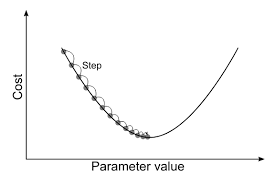

Идея импульса заключается в том, чтобы подобрать именно такую величину шага (скорость обучения), чтобы целевая функция попала в точку локального минимума, а не перескочила ее.

##Сохранение и загрузка

In [ ]:
#net1, net2, net3, net4 = Net1(), Net2(), Net3(),Net4()
#models = [net1, net2, net3, net4]
for i, model in enumerate(models):
    PATH = f'./cnn{i+1}.pth'
    torch.save(model.state_dict(), PATH)
    model.load_state_dict(torch.load(PATH))

##Тестирование

In [ ]:
def accforcnn():
    # Подготовка
    correct_pred = {classname: 0 for classname in dataset.classes}
    total_pred = {classname: 0 for classname in dataset.classes}
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_dl:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predictions = torch.max(outputs, 1)
            
            # собираем правильные прогнозы для каждого класса
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    # правильные предсказания для этого класса    
                    correct_pred[dataset.classes[label]] += 1
                    # все правильные предсказания    
                    correct += 1
                # все предсказания для этого класса
                total_pred[dataset.classes[label]] += 1
                # все предсказания
                total += 1

    print(f'Accuracy of the network on test images: {100 * correct // total} %')
    # Выводим точность на каждом классе
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print(f'Accuracy for class {classname:11s}: {correct_count} / {total_pred[classname]} \t is {accuracy:.1f} %')

In [ ]:
for i, model in enumerate(models):
    PATH = f'./cnn{i+1}.pth'
    model.load_state_dict(torch.load(PATH))
    model.eval()
    accforcnn()

Accuracy of the network on test images: 38 %
Accuracy for class Agaricus   : 8 / 59 	 is 13.6 %
Accuracy for class Amanita    : 41 / 116 	 is 35.3 %
Accuracy for class Boletus    : 76 / 162 	 is 46.9 %
Accuracy for class Cortinarius: 41 / 119 	 is 34.5 %
Accuracy for class Entoloma   : 5 / 55 	 is 9.1 %
Accuracy for class Hygrocybe  : 14 / 48 	 is 29.2 %
Accuracy for class Lactarius  : 127 / 222 	 is 57.2 %
Accuracy for class Russula    : 68 / 170 	 is 40.0 %
Accuracy for class Suillus    : 1 / 49 	 is 2.0 %
Accuracy of the network on test images: 22 %
Accuracy for class Agaricus   : 0 / 59 	 is 0.0 %
Accuracy for class Amanita    : 0 / 116 	 is 0.0 %
Accuracy for class Boletus    : 0 / 162 	 is 0.0 %
Accuracy for class Cortinarius: 0 / 119 	 is 0.0 %
Accuracy for class Entoloma   : 0 / 55 	 is 0.0 %
Accuracy for class Hygrocybe  : 0 / 48 	 is 0.0 %
Accuracy for class Lactarius  : 222 / 222 	 is 100.0 %
Accuracy for class Russula    : 0 / 170 	 is 0.0 %
Accuracy for class Suillus    : 

In [ ]:
PATH = f'./cnnNet4.pth'
torch.save(net4.state_dict(), PATH)
net4.load_state_dict(torch.load(PATH))
net4.eval()
accforcnn()

Accuracy of the network on test images: 40 %
Accuracy for class Agaricus   : 17 / 59 	 is 28.8 %
Accuracy for class Amanita    : 44 / 116 	 is 37.9 %
Accuracy for class Boletus    : 97 / 162 	 is 59.9 %
Accuracy for class Cortinarius: 32 / 119 	 is 26.9 %
Accuracy for class Entoloma   : 12 / 55 	 is 21.8 %
Accuracy for class Hygrocybe  : 8 / 48 	 is 16.7 %
Accuracy for class Lactarius  : 139 / 222 	 is 62.6 %
Accuracy for class Russula    : 57 / 170 	 is 33.5 %
Accuracy for class Suillus    : 3 / 49 	 is 6.1 %


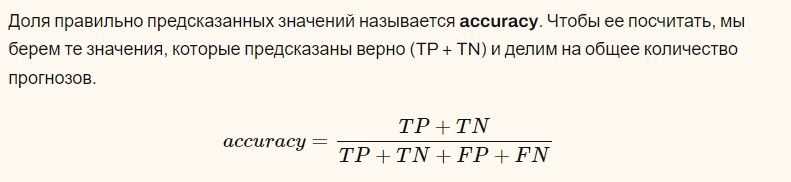

#Тестирование на других сетях

##AlexNet

In [ ]:
from torchvision import models as torchmodels
alexmodel = torchmodels.alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False

C:\Users\anvit\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\anvit\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\anvit/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
100%|███████████████████████████████████████████████████████████████████████████████| 233M/233M [00:10<00:00, 24.1MB/s]


In [ ]:
alexmodel.train(True)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [ ]:
from torch.optim import Adam
from torch.autograd import Variable

num_epochs = 10

model = model.to(device)
best_alex_model = None
best_loss = 99999999999999.9
best_epoch = -1

optimizer=Adam(alexmodel.classifier.parameters(), lr=0.001)
loss_function=nn.CrossEntropyLoss()

# засекаем время
start_time = timer(None)
for epoch in range(num_epochs):
    alexmodel.train()
    epoch_loss = 0.0

    for i, (images, labels) in enumerate(train_dl):
        images = images.to(device)
        labels = labels.to(device)
        # обнуляем градиенты параметров
        optimizer.zero_grad()      
        outputs = alexmodel(images)
        # loss смотрит, насколько далеко находятся полученные ответы от реальных
        loss=loss_function(outputs,labels)
        # вычисляем градиенты  
        loss.backward()
        optimizer.step()

        # вывести статистику обучения
        epoch_loss += loss.item()     
    print (f'Epoch [{epoch+1}], Loss: {epoch_loss:.4f}')

    # находим самую лучшую эпоху
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        best_model = alexmodel.state_dict()
        best_epoch = epoch
best_models.append(best_model)

print(f'Finished Training AlexNet. Best epoch: {best_epoch+1}\n')
# сколько времени работала 1 модель
timer(start_time)


Epoch [1], Loss: 239.0895
Epoch [2], Loss: 216.7269
Epoch [3], Loss: 196.3431
Epoch [4], Loss: 177.8740
Epoch [5], Loss: 163.6328
Epoch [6], Loss: 153.2487
Epoch [7], Loss: 139.4427
Epoch [8], Loss: 128.2147
Epoch [9], Loss: 120.7308
Epoch [10], Loss: 111.4647
Finished Training AlexNet. Best epoch: 10

Затрачено времени: 0 часов 25 минут и 26.57 секунд.



In [ ]:
PATH = f'./cnnAlex.pth'
torch.save(alexmodel.state_dict(), PATH)
alexmodel.load_state_dict(torch.load(PATH))
alexmodel.eval()
accforcnn()

Accuracy of the network on test images: 30 %
Accuracy for class Agaricus   : 0 / 59 	 is 0.0 %
Accuracy for class Amanita    : 14 / 116 	 is 12.1 %
Accuracy for class Boletus    : 77 / 162 	 is 47.5 %
Accuracy for class Cortinarius: 11 / 119 	 is 9.2 %
Accuracy for class Entoloma   : 0 / 55 	 is 0.0 %
Accuracy for class Hygrocybe  : 6 / 48 	 is 12.5 %
Accuracy for class Lactarius  : 172 / 222 	 is 77.5 %
Accuracy for class Russula    : 29 / 170 	 is 17.1 %
Accuracy for class Suillus    : 0 / 49 	 is 0.0 %


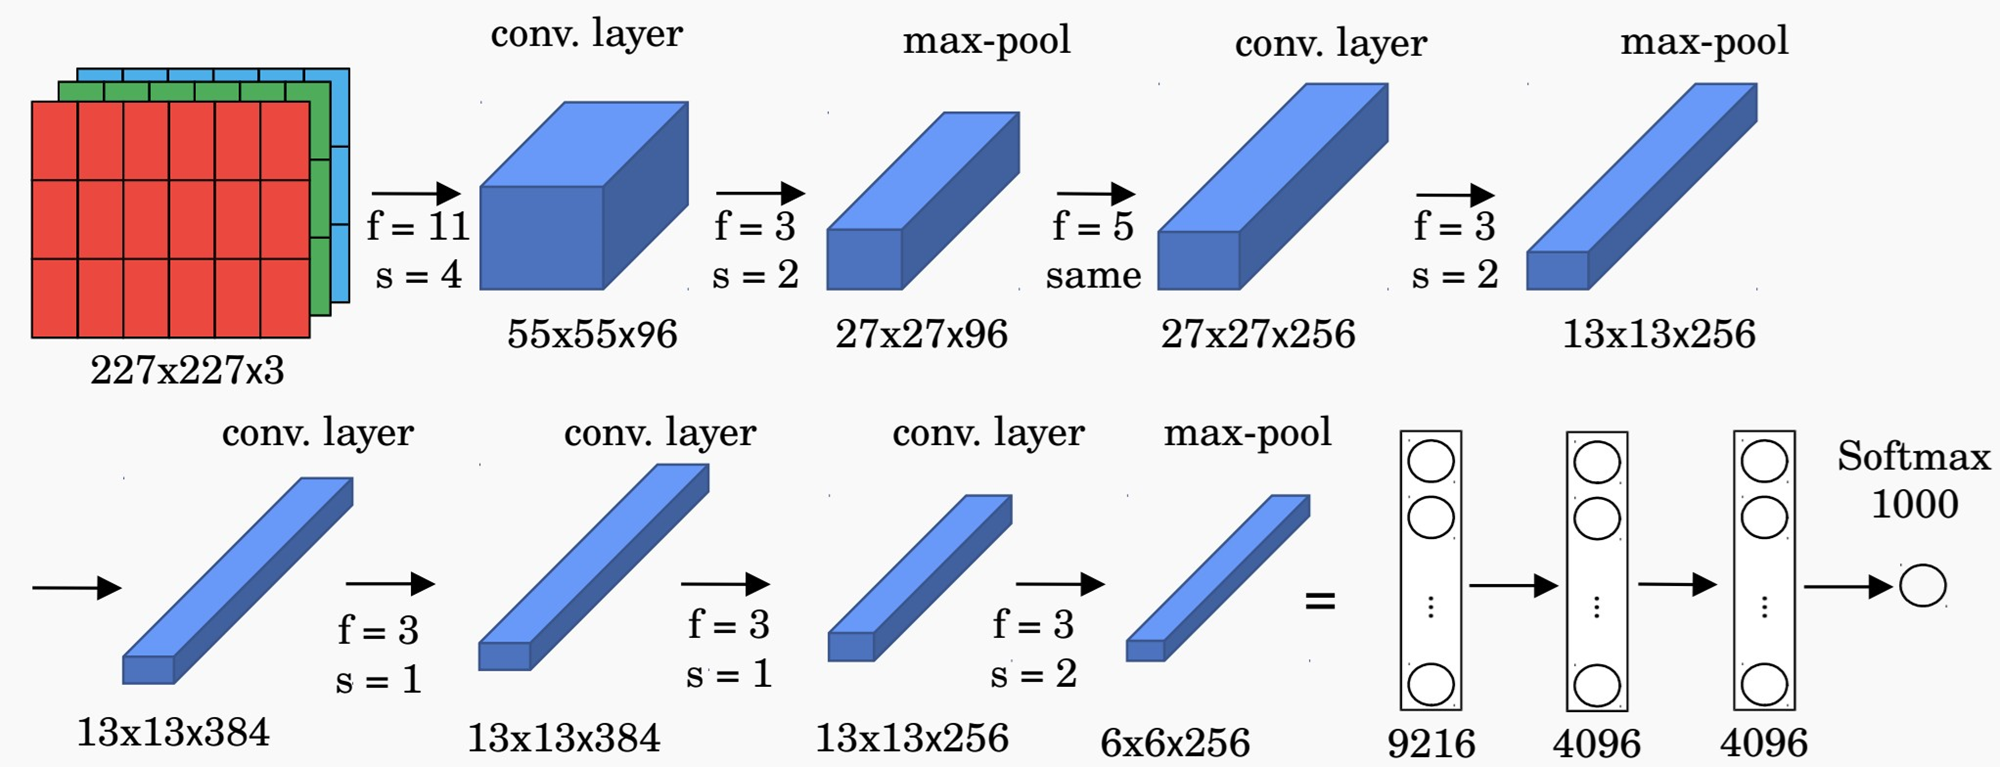

#Заметки

backword - расчет градиентов функции (производных)

Оптимизация – это процесс настройки Гиперпараметров для минимизации Целевой функции (Cost Function). Иными словами, это набор методов совершенствования Модели Машинного обучения.

Softmax

Функция 𝑠𝑜𝑓𝑡𝑚𝑎𝑥(𝑧) преобразует вектор 𝑧 размерности 𝑛 в вектор той же размерности, где каждая координата полученного вектора представлена вещественным числом в интервале [0,1] и сумма координат равна 1.

accuracy

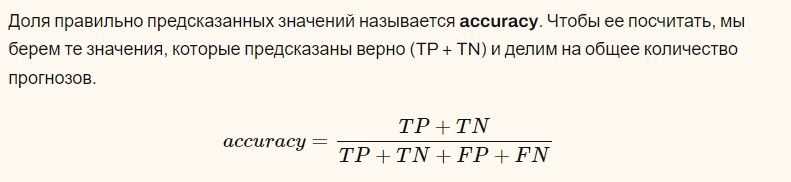

**Adam** объединяет в себе преимущества RMSProp, AdaGrad и SGD+Momentum. Сначала мы выполняем оценку первого импульса и взвешенной суммы градиентов, а затем оцениваем второй импульс и квадрат градиентов. Первый импульс играет роль скорости, а второй служит для оптимизации параметров.

Нормализация - выравнивание данных в один диапазон

Батч нормализация. мат ожидание=0, дисперсия=1

Кросс энтропия измеряет расхождение между двумя вероятностными распределениями

In [ ]:
worker_per_gpu = 0 # помогает исправить ошибку  Caught OSError in DataLoader worker process 0